**Table of contents**<a id='toc0_'></a>    
- [Image classification example](#toc1_)    
- [Pretrained Image classification example - ResNet18](#toc2_)    
- [Pretrained Image classification example - Transformer](#toc3_)    
- [Sequential classification (Unsupported for now)](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [6]:
openml.config.apikey = ''

# Image classification task

In [1]:
import torch.nn
import torch.optim

import openml
import openml_pytorch
import openml_pytorch.layers
import openml_pytorch.config
from openml import OpenMLTask
import logging
import warnings
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda

from openml_pytorch.trainer import convert_to_rgb
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')

############################################################################
# Enable logging in order to observe the progress while running the example.
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
############################################################################

############################################################################
import torch.nn as nn
import torch.nn.functional as F

from openml_pytorch.trainer import OpenMLTrainerModule
from openml_pytorch.trainer import OpenMLDataModule
from openml_pytorch.trainer import Callback

import torchvision.models as models
import torchvision
from openml_pytorch.callbacks import *
from openml_pytorch.metrics import *
from torch.utils.tensorboard import SummaryWriter

In [ ]:
transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((64, 64)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size=64,
    transform=transform,
)
# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362128)
model = torchvision.models.resnet18(num_classes=200)

# Tensorboard support
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(comment="resnet18", log_dir = f"testlogs/{timestamp}")

trainer = OpenMLTrainerModule(
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    callbacks=[
        openml_pytorch.callbacks.TestCallback,
        partial(TensorBoardCallback, writer),
    ],
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

Loss tensor(5.4571, device='mps:0', grad_fn=<NllLossBackward0>)


Loss tensor(5.3861, device='mps:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/51 [00:00<?, ?it/s]

In [5]:
run.publish()

OpenML Run
Uploader Name...................: None
Metric..........................: None
Local Result - Accuracy (+- STD): 0.0055 +- 0.0033
Run ID..........................: 10595158
Run URL.........................: https://www.openml.org/r/10595158
Task ID.........................: 362128
Task Type.......................: None
Task URL........................: https://www.openml.org/t/362128
Flow ID.........................: 25011
Flow Name.......................: torch.nn.ResNet.2a12408ac25b016a
Flow URL........................: https://www.openml.org/f/25011
Setup ID........................: None
Setup String....................: Python_3.11.9. Torch_2.4.1. NumPy_1.26.4. SciPy_1.14.1. ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


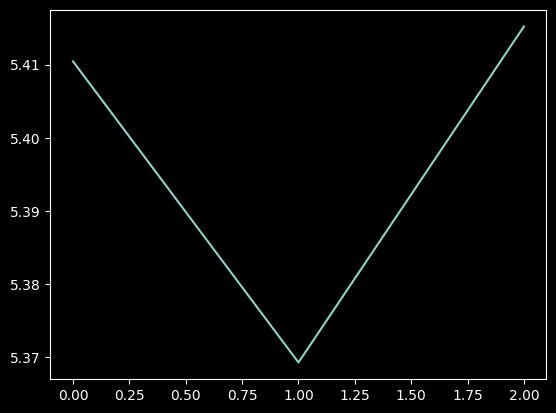

In [5]:
trainer.plot_loss()

[0.0001000000000000187, 0.0003329371058325051, 0.0010098248822835592]

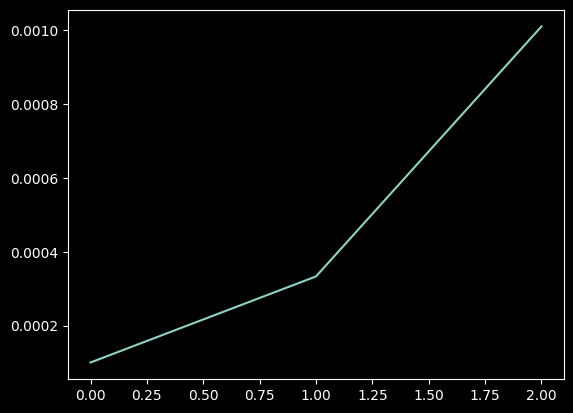

In [6]:
trainer.plot_lr()

In [7]:
trainer.model_classes

array(['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640',
       'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750',
       'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289',
       'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695',
       'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620',
       'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799',
       'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165',
       'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429',
       'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972',
       'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003',
       'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495',
       'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196',
       'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148',
       'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n028

In [8]:
trainer.export_to_netron(onnx_file_name="model.onnx")

Writing onnx model to model.onnx. Delete if neeeded
Serving 'model.onnx' at http://localhost:8080


# Sequential classification (Old example MNIST)

In [10]:

import torch.nn
import torch.optim

import openml_pytorch.config
import openml
import logging
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')

############################################################################
# Enable logging in order to observe the progress while running the example.
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
############################################################################

In [11]:
from openml_pytorch.trainer import OpenMLTrainerModule
from openml_pytorch.trainer import OpenMLDataModule

In [12]:

############################################################################
# Define a sequential network that does the initial image reshaping
# and normalization model.
processing_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 1, 28, 28)),
    torch.nn.BatchNorm2d(num_features=1)
)
############################################################################

############################################################################
# Define a sequential network that does the extracts the features from the
# image.
features_net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
)
############################################################################

############################################################################
# Define a sequential network that flattens the features and compiles the
# results into probabilities for each digit.
results_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 4 * 4 * 64)),
    torch.nn.Linear(in_features=4 * 4 * 64, out_features=256),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=256, out_features=10),
)
############################################################################
# openml.config.apikey = 'key'

############################################################################
# The main network, composed of the above specified networks.
model = torch.nn.Sequential(
    processing_net,
    features_net,
    results_net
)
############################################################################


In [14]:
data_module = OpenMLDataModule(
    type_of_data="dataframe",
    filename_col="class",
    target_mode="categorical",
)

In [15]:

trainer = OpenMLTrainerModule(
    data_module=data_module,
    verbose = True,
    epoch_count = 1,
)
openml_pytorch.config.trainer = trainer

In [16]:
# Download the OpenML task for the mnist 784 dataset.
task = openml.tasks.get_task(3573)

In [17]:
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model Sequential(
  (0): Sequential(
    (0): Functional()
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Functional()
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) on dataset mnist_784 for repeat 0 fold 0 sample 0


train: [0.37000785383597884, tensor(0.8802, device='mps:0')]
valid: [0.06105882432725694, tensor(0.9798, device='mps:0')]
Loss tensor(0.1303, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model Sequential(
  (0): Sequential(
    (0): Functional()
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Functional()
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) on dataset mnist_784 for repeat 0 fold 1 sample 0


train: [0.3643697296626984, tensor(0.8875, device='mps:0')]
valid: [0.05847218831380208, tensor(0.9806, device='mps:0')]
Loss tensor(0.2014, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model Sequential(
  (0): Sequential(
    (0): Functional()
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Functional()
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) on dataset mnist_784 for repeat 0 fold 2 sample 0


train: [0.3116477210097002, tensor(0.9034, device='mps:0')]
valid: [0.05281951904296875, tensor(0.9852, device='mps:0')]
Loss tensor(0.1903, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model Sequential(
  (0): Sequential(
    (0): Functional()
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Functional()
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) on dataset mnist_784 for repeat 0 fold 3 sample 0


train: [0.3643473048941799, tensor(0.8850, device='mps:0')]
valid: [0.07235263400607639, tensor(0.9790, device='mps:0')]
Loss tensor(0.2772, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model Sequential(
  (0): Sequential(
    (0): Functional()
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Functional()
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) on dataset mnist_784 for repeat 0 fold 4 sample 0


train: [0.33402395419973546, tensor(0.8938, device='mps:0')]
valid: [0.06707420228019594, tensor(0.9817, device='mps:0')]
Loss tensor(0.2481, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model Sequential(
  (0): Sequential(
    (0): Functional()
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Functional()
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) on dataset mnist_784 for repeat 0 fold 5 sample 0


train: [0.3635254422949735, tensor(0.8826, device='mps:0')]
valid: [0.06506180051773314, tensor(0.9811, device='mps:0')]
Loss tensor(0.0397, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model Sequential(
  (0): Sequential(
    (0): Functional()
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Functional()
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) on dataset mnist_784 for repeat 0 fold 6 sample 0


train: [0.38557877259700174, tensor(0.8777, device='mps:0')]
valid: [0.06910077776227679, tensor(0.9816, device='mps:0')]
Loss tensor(0.0020, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model Sequential(
  (0): Sequential(
    (0): Functional()
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Functional()
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) on dataset mnist_784 for repeat 0 fold 7 sample 0


train: [0.3358298542217813, tensor(0.8956, device='mps:0')]
valid: [0.07069795154389881, tensor(0.9813, device='mps:0')]
Loss tensor(0.0143, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model Sequential(
  (0): Sequential(
    (0): Functional()
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Functional()
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) on dataset mnist_784 for repeat 0 fold 8 sample 0


train: [0.33729483575837743, tensor(0.8953, device='mps:0')]
valid: [0.07018110971602183, tensor(0.9821, device='mps:0')]
Loss tensor(0.1584, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model Sequential(
  (0): Sequential(
    (0): Functional()
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Functional()
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
) on dataset mnist_784 for repeat 0 fold 9 sample 0


train: [0.3252566964285714, tensor(0.8973, device='mps:0')]
valid: [0.07023202563089037, tensor(0.9816, device='mps:0')]
Loss tensor(0.3708, device='mps:0')


INFO:openml.config:Executed Task 3573 on local Flow with name torch.nn.Sequential.bb8de941c9933dd2.


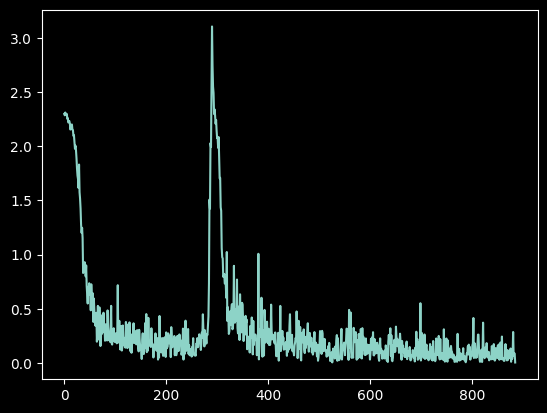

In [18]:
trainer.runner.cbs[1].plot_loss()

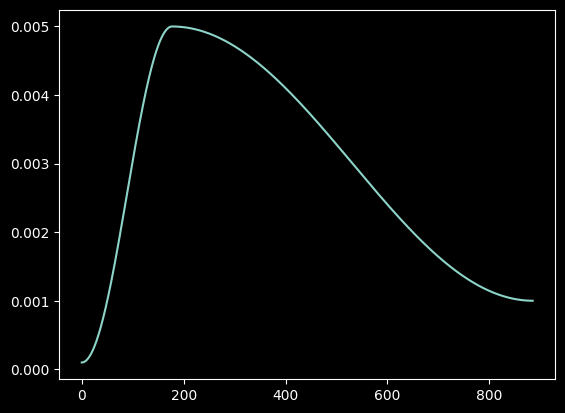

In [19]:
trainer.runner.cbs[1].plot_lr()

In [22]:
run.publish()

OpenML Run
Uploader Name...................: None
Metric..........................: None
Local Result - Accuracy (+- STD): 0.9814 +- 0.0015
Run ID..........................: 10595159
Run URL.........................: https://www.openml.org/r/10595159
Task ID.........................: 3573
Task Type.......................: None
Task URL........................: https://www.openml.org/t/3573
Flow ID.........................: 25079
Flow Name.......................: torch.nn.Sequential.bb8de941c9933dd2
Flow URL........................: https://www.openml.org/f/25079
Setup ID........................: None
Setup String....................: Python_3.11.9. Torch_2.4.1. NumPy_1.26.4. SciPy_1.14.1. Sequential(
  (0): Sequential(
    (0): Functional()
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride

# <a id='toc3_'></a>[Pretrained Image classification example - Transformer](#toc0_)

In [23]:
import torch.nn
import torch.optim

import openml
import openml_pytorch
import openml_pytorch.layers
import openml_pytorch.config
import logging
import warnings
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
from openml_pytorch.trainer import convert_to_rgb
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')

############################################################################
# Enable logging in order to observe the progress while running the example.
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
############################################################################

############################################################################
import torch.nn as nn
import torch.nn.functional as F

In [24]:
# openml.config.apikey = 'key'
from openml_pytorch.trainer import OpenMLTrainerModule
from openml_pytorch.trainer import OpenMLDataModule
from openml_pytorch.trainer import Callback

In [25]:
from openml import OpenMLTask
def custom_optimizer_gen(model: torch.nn.Module, task: OpenMLTask) -> torch.optim.Optimizer:
    return torch.optim.Adam(model.fc.parameters())

############################################################################
transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(
            convert_to_rgb
        ),  # Convert PIL Image to RGB if it's not already.
        Resize(
            (64, 64)
        ),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size = 64,
    transform=transform
)
# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362128)

trainer = OpenMLTrainerModule(
    data_module=data_module,
    verbose = True,
    epoch_count = 1,
    optimizer = custom_optimizer_gen
)
openml_pytorch.config.trainer = trainer

In [26]:
# Example model. You can do better :)
import torchvision.models as models

# Load the pre-trained ResNet model
model = models.efficientnet_b0(pretrained=True)

# Modify the last fully connected layer to the required number of classes
num_classes = 200
in_features = model.classifier[-1].in_features
# model.fc = nn.Linear(in_features, num_classes)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, num_classes),
)

# Optional: If you're fine-tuning, you may want to freeze the pre-trained layers
# for param in model.parameters():
#     param.requires_grad = False

# # If you want to train the last layer only (the newly added layer)
# for param in model.fc.parameters():
#     param.requires_grad = True

In [27]:
#
# Run the model on the task (requires an API key).m
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

train: [5.486830873842592, tensor(0.0065, device='mps:0')]
valid: [5.498468017578125, tensor(0.0083, device='mps:0')]
Loss tensor(5.6186, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

train: [5.534859664351852, tensor(0.0043, device='mps:0')]
valid: [5.557652452256945, tensor(0.0056, device='mps:0')]
Loss tensor(5.6452, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

train: [5.5046585648148145, tensor(0.0059, device='mps:0')]
valid: [5.664307657877604, tensor(0.0028, device='mps:0')]
Loss tensor(5.8150, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

train: [5.49383861400463, tensor(0.0046, device='mps:0')]
valid: [5.487301974826389, tensor(0.0028, device='mps:0')]
Loss tensor(5.5008, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

train: [5.507443576388889, tensor(0.0062, device='mps:0')]
valid: [5.3962646484375, tensor(0.0083, device='mps:0')]
Loss tensor(5.3565, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

train: [5.524650366512346, tensor(0.0052, device='mps:0')]
valid: [5.57498541937934, tensor(0., device='mps:0')]
Loss tensor(5.4743, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

train: [5.530463927469135, tensor(0.0068, device='mps:0')]
valid: [5.956352403428819, tensor(0.0083, device='mps:0')]
Loss tensor(6.2169, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

train: [5.506794945987655, tensor(0.0056, device='mps:0')]
valid: [5.932855902777778, tensor(0., device='mps:0')]
Loss tensor(6.6748, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

train: [5.516219979745371, tensor(0.0049, device='mps:0')]
valid: [6.410263400607639, tensor(0.0056, device='mps:0')]
Loss tensor(5.7348, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

train: [5.494152681327161, tensor(0.0065, device='mps:0')]
valid: [5.389304606119792, tensor(0.0083, device='mps:0')]
Loss tensor(5.4360, device='mps:0')


INFO:openml.config:Executed Task 362128 on local Flow with name torch.nn.EfficientNet.e18645453fee0ec6.


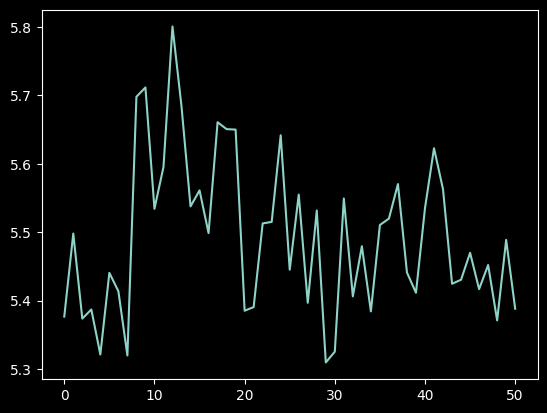

In [28]:
trainer.runner.cbs[1].plot_loss()

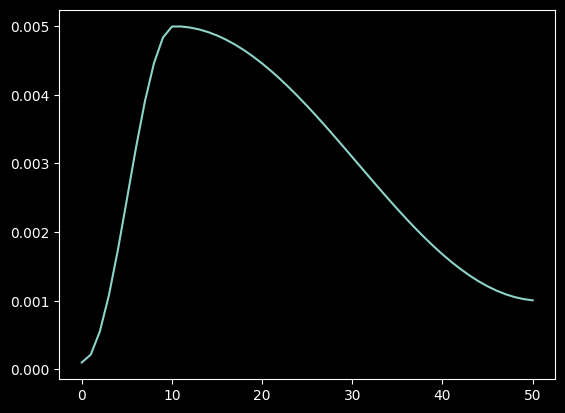

In [29]:
trainer.runner.cbs[1].plot_lr()

# Tabular classification

In [30]:

import torch.nn
import torch.optim

import openml
import openml_pytorch
import openml_pytorch.layers
import openml_pytorch.config
import logging


############################################################################
# Enable logging in order to observe the progress while running the example.
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
############################################################################

In [31]:
from openml_pytorch.trainer import OpenMLTrainerModule
from openml_pytorch.trainer import OpenMLDataModule
from openml_pytorch.trainer import Callback
import torchvision

In [32]:
# supervised credit-g classification
task = openml.tasks.get_task(31)

In [33]:
data_module = OpenMLDataModule(
    type_of_data="dataframe",
    target_column="class",
    target_mode="categorical",
)

In [34]:

trainer = OpenMLTrainerModule(
    data_module=data_module,
    verbose = True,
    epoch_count = 5,
)
openml_pytorch.config.trainer = trainer

In [35]:
data = task.get_dataset().get_data()[0]

In [36]:
class TabularClassificationmodel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(TabularClassificationmodel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, output_size)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [37]:
model = TabularClassificationmodel(20, 2)

In [38]:
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
) on dataset credit-g for repeat 0 fold 0 sample 0


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
) on dataset credit-g for repeat 0 fold 1 sample 0


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
) on dataset credit-g for repeat 0 fold 2 sample 0


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
) on dataset credit-g for repeat 0 fold 3 sample 0


valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
) on dataset credit-g for repeat 0 fold 4 sample 0


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
) on dataset credit-g for repeat 0 fold 5 sample 0


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
) on dataset credit-g for repeat 0 fold 6 sample 0


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
) on dataset credit-g for repeat 0 fold 7 sample 0


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
) on dataset credit-g for repeat 0 fold 8 sample 0


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
) on dataset credit-g for repeat 0 fold 9 sample 0


valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


INFO:openml.config:Executed Task 31 on local Flow with name torch.nn.TabularClassificationmodel.481f5d46717292fa.


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


In [39]:
run.publish()

OpenML Run
Uploader Name...................: None
Metric..........................: None
Local Result - Accuracy (+- STD): 0.7000 +- 0.0000
Run ID..........................: 10595160
Run URL.........................: https://www.openml.org/r/10595160
Task ID.........................: 31
Task Type.......................: None
Task URL........................: https://www.openml.org/t/31
Flow ID.........................: 25096
Flow Name.......................: torch.nn.TabularClassificationmodel.481f5d46717292fa
Flow URL........................: https://www.openml.org/f/25096
Setup ID........................: None
Setup String....................: Python_3.11.9. Torch_2.4.1. NumPy_1.26.4. SciPy_1.14.1. TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
Dataset ID......................: 

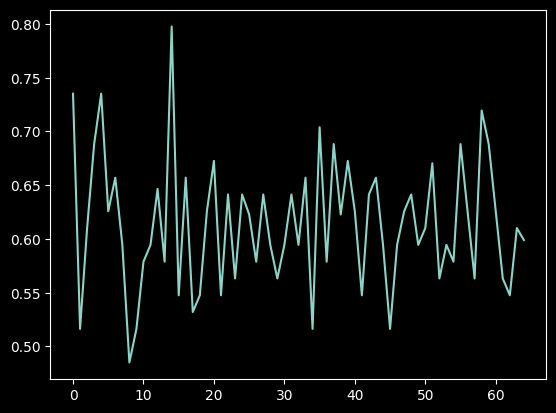

In [40]:
trainer.runner.cbs[1].plot_loss()

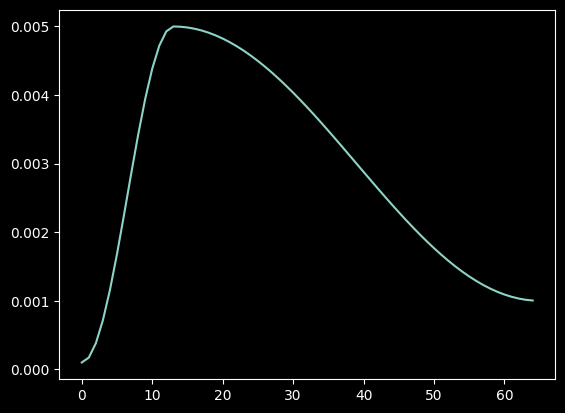

In [41]:
trainer.runner.cbs[1].plot_lr()